The upshot of these experiments is that, when the encounter distance is one vortex diameter or closer, 70% of the time or better we retreive fit parameters that are within 50% of the correct values.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from statsmodels.robust import mad
from numpy.random import normal

# Include the utils functions
from utils import *

import warnings
warnings.filterwarnings('ignore')

boxcar_window_size = 3001
matched_filter_window_length = (3000./3600)
matched_filter_depth = 1./np.pi
matched_filter_fwhm = 1./3600
detection_threshold = 5.
matched_filter_num_fwhm = 15

Gamma_min = 0.5
Gamma_max = 100
P_min = 0.1

# For the pre-detection of vortices calculations
num_sig = 5.

min_b_over_Dact = 0.2
max_b_over_Dact = 3.
num_Vobs_sig = 3.

dr="/Users/bjackson/Downloads/ps_bundle/data_calibrated"
dr_wind = '/Users/bjackson/Downloads/twins_bundle/data_derived'
# dr="/Users/brian/Downloads/ps_bundle/data_calibrated"
# dr_wind = '/Users/brian/Downloads/twins_bundle/data_derived'

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

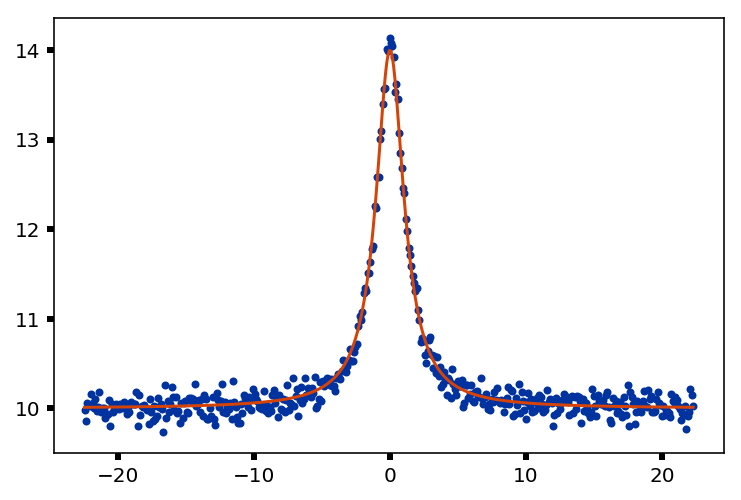

In [2]:
t0 = 0.
sampling=0.1
time_offset = normal(scale=sampling/2.)

Pact = 5. # Pa
Dact = 10. # m
density = 0.2 # kg/m^3
Vact = np.sqrt(Pact/density) # cyclostrophic balance

wind_sigma = 0.1 # m/s noise

U1 = 10.
U2 = 10.

bs = Dact
Dobs = np.sqrt(Dact**2 + (2.*bs)**2)
Gamma_obs = Dobs/U1
Vobs = (2.*Vact*(2.*bs/Dact)/(1. + (2.*bs/Dact)**2))
Pobs = Pact/(1. + (2.*bs/Dact)**2)

t = np.arange(-10.*Gamma_obs, 10.*Gamma_obs, sampling) + time_offset

# U1 and U2 set equal!
profile = wind_profile(t, t0, Vobs, U1, U1, bs, Gamma_obs)
noisy_profile = profile + normal(scale=wind_sigma, size=len(t))

plt.scatter(t, noisy_profile, marker='.', color=BoiseState_blue)
plt.plot(t, profile, color=BoiseState_orange)

[ 3.98452904 11.76019731] [0.03308563 0.94313041] 10.041326485289874 10.031017722445636
4.0 10.0 10.0 10.0
4.850215297219661 4.924538200288256 10.15323629677058 9.961322611756188
5.0 5.0 10.0 10.0


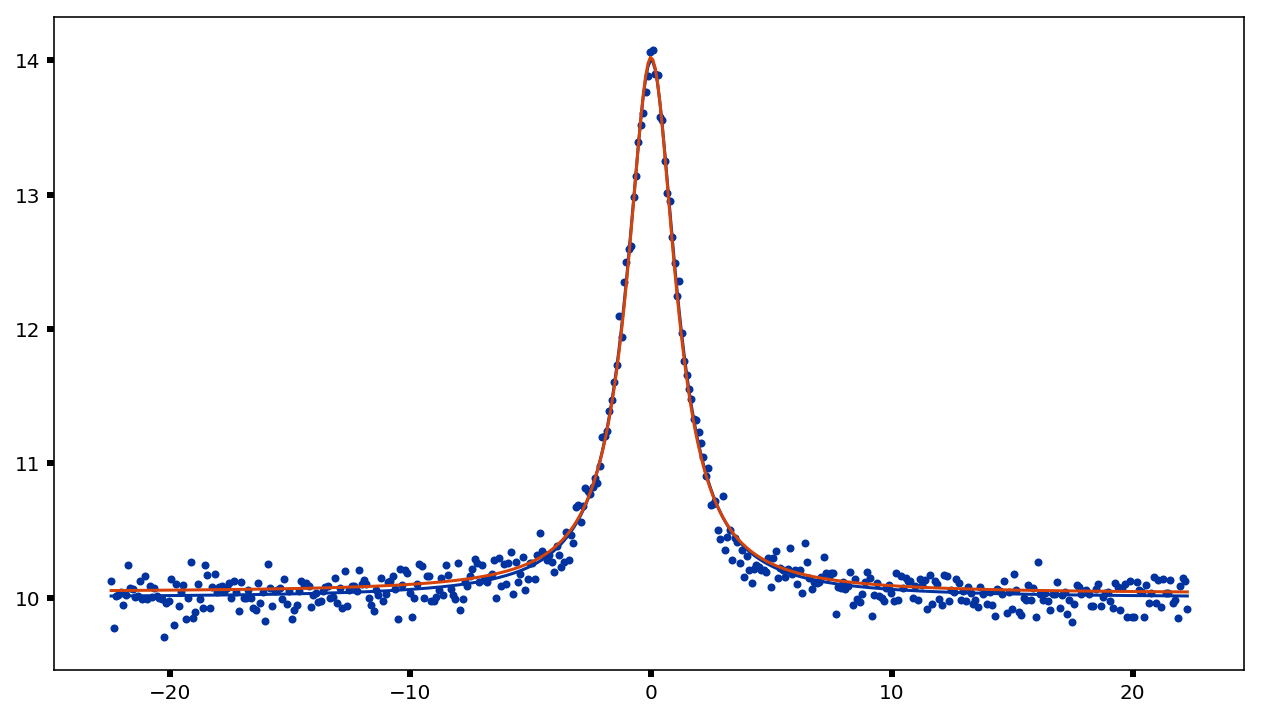

In [3]:
profile = wind_profile(t, t0, Vobs, U1, U2, bs, Gamma_obs)
noisy_profile = profile + normal(scale=wind_sigma, size=len(t))

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax1 = fig.add_subplot(111)

ax1.plot(t, wind_profile(t, t0, Vobs, U1, U2, bs, Gamma_obs), color=BoiseState_blue)

popt, uncertainties, fit_U1, fit_U2 = fit_wind_profile(t, noisy_profile, wind_sigma, 0., Gamma_obs, 
                                       [np.sign(Vobs)*1., np.sign(bs)*1.])        
print(popt, uncertainties, fit_U1, fit_U2)
print(Vobs, bs, U1, U2)
fit_Pact, fit_Vact, fit_Dact, fit_bact = calculate_act_values(density, popt[0], Pobs, Dobs)
print(fit_Pact, fit_Vact, fit_Dact, fit_bact)
print(Pact, Vact, Dact, bs)

ax1.scatter(t, noisy_profile, color=BoiseState_blue, marker='.')
ax1.plot(t, wind_profile(t, t0, popt[0], fit_U1, fit_U2, popt[1], Gamma_obs), color=BoiseState_orange)

(-2, 2)

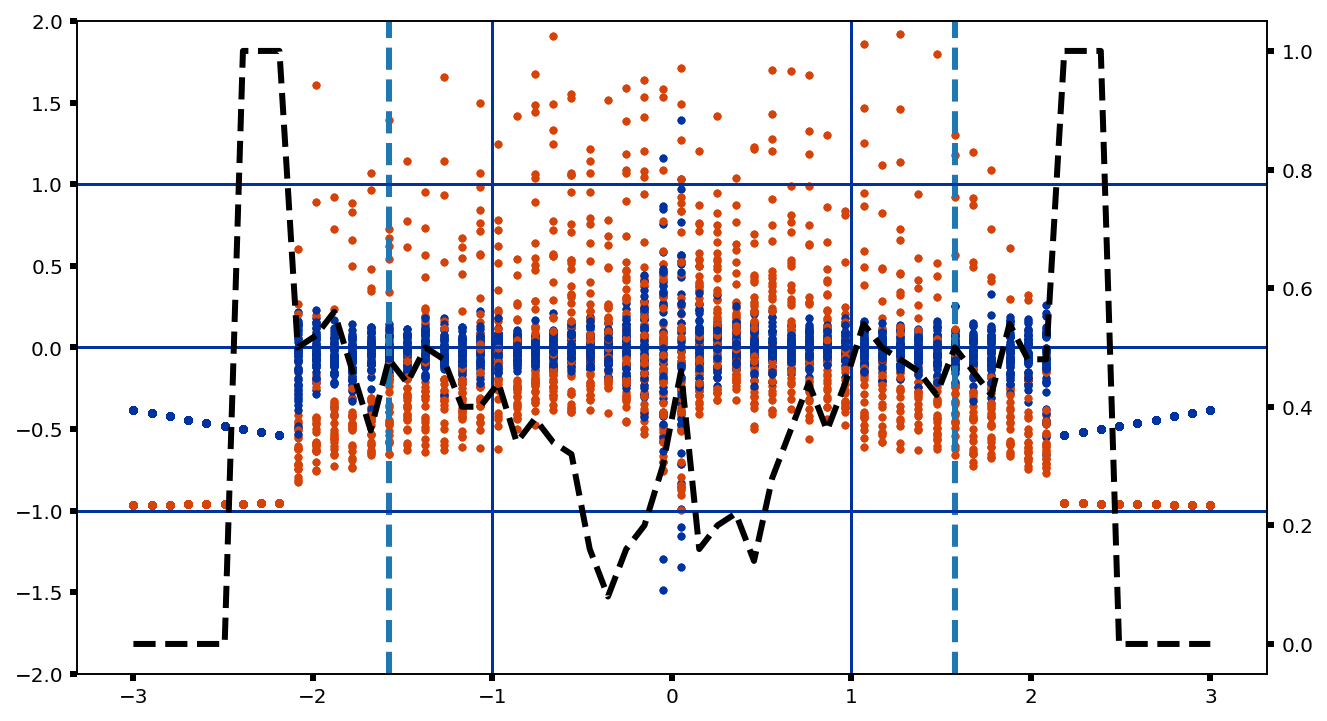

In [9]:
# How often do the best-fit Vobs and b-values differ and by how much from the correct, assumed values?
# 
# 2020 Dec 29 - 

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

wind_sigma = 1. # m/s noise

margin = 0.5 # Within 50% of the right value

num_bs = 60
num_tries = 50
bs = np.linspace(-3.*Dact, 3.*Dact, num_bs)

Dobs = np.sqrt(Dact**2 + (2.*bs)**2)
Gamma_obs = Dobs/U1
Vobs = np.abs((2.*Vact*(2.*bs/Dact)/(1. + (2.*bs/Dact)**2)))
Pobs = Pact/(1. + (2.*bs/Dact)**2)

# Show where we expect not to be able to return a good fit
ind = (Vobs <= 3.*wind_sigma) & (bs/Dact < -1.)
ax1.axvline(np.max(bs[ind]/Dact), lw=3, ls='--')

ind = (Vobs <= 3.*wind_sigma) & (bs/Dact > 1.)
ax1.axvline(np.min(bs[ind]/Dact), lw=3, ls='--')

num_wrongs = np.zeros_like(bs)

for i in range(len(bs)):
    for j in range(num_tries):
    
        profile = wind_profile(t, t0, Vobs[i], U1, U2, bs[i], Gamma_obs[i])
        noisy_profile = profile + normal(scale=wind_sigma, size=len(t))

        try:
            popt, uncertainties, fit_U1, fit_U2 = fit_wind_profile(t, noisy_profile, wind_sigma, 0., Gamma_obs[i], 
                                                   [np.sign(Vobs[i])*1., np.sign(bs[i])*1.])

            if((np.abs((popt[0] - Vobs[i])/Vobs[i]) > margin) or\
               ((np.abs(popt[1]) - np.abs(bs[i]))/np.abs(bs[i]) > margin)):
    #             print(i, bs[i]/Dact, (popt[0] - Vobs)/Vobs, popt[0], Vobs)

                num_wrongs[i] += 1

    #         if((np.abs(popt[3]) - np.abs(bs[i]))/np.abs(bs[i]) > 2):
    #             print(bs[i]/Dact, (np.abs(popt[3]) - np.abs(bs[i]))/np.abs(bs[i]), popt[3], bs[i])

            # Vobs
            ax1.scatter([bs[i]/Dact, bs[i]/Dact], [(popt[0] - Vobs[i])/Vobs[i], (popt[0] - Vobs[i])/Vobs[i]], 
                       marker='.', color=BoiseState_blue)
            # bs
            ax1.scatter([bs[i]/Dact, bs[i]/Dact], 
                        [(np.abs(popt[1]) - np.abs(bs[i]))/np.abs(bs[i]), 
                         (np.abs(popt[1]) - np.abs(bs[i]))/np.abs(bs[i])], 
                       marker='.', color=BoiseState_orange)        

        except:
            print("%g didn't work!" % (bs[i]/Dact))

ax2.plot(bs/Dact, num_wrongs/num_tries, color='k', lw=3, ls='--')
            
ax1.axhline(-1, color=BoiseState_blue)
ax1.axhline(1, color=BoiseState_blue)
ax1.axvline(-1, color=BoiseState_blue)
ax1.axvline(1, color=BoiseState_blue)
ax1.axhline(0., color=BoiseState_blue)
ax1.set_ylim([-2, 2])

(-3, 3)

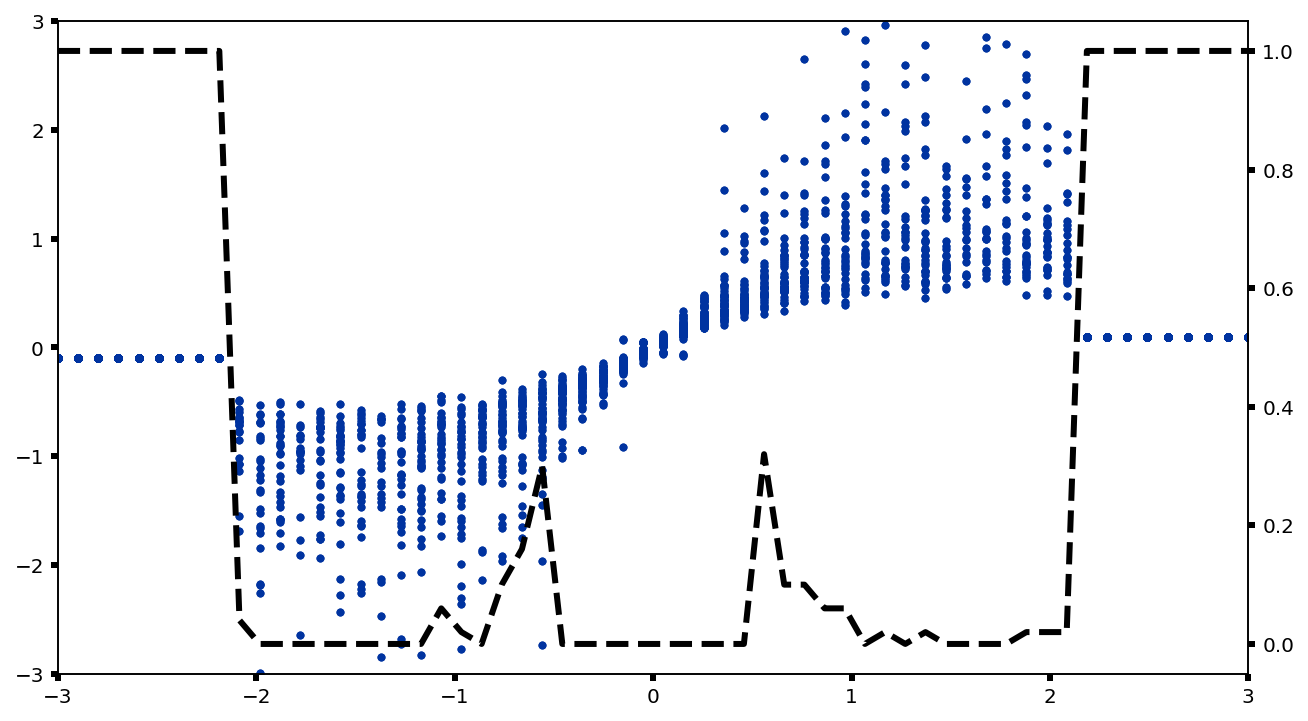

In [8]:
# When the correct, assumed b/Dact-value > 1, how often is the best-fit value returned less than 1?

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

wind_sigma = 1. # m/s noise

margin = 0.5 # Within 50% of the right value

num_bs = 60
num_tries = 50
bs = np.linspace(-3.*Dact, 3.*Dact, num_bs)

Dobs = np.sqrt(Dact**2 + (2.*bs)**2)
Gamma_obs = Dobs/U1
Vobs = np.abs((2.*Vact*(2.*bs/Dact)/(1. + (2.*bs/Dact)**2)))
Pobs = Pact/(1. + (2.*bs/Dact)**2)

# # Show where we expect not to be able to return a good fit
# ind = (Vobs <= 3.*wind_sigma) & (bs/Dact < -1.)
# ax1.axvline(np.max(bs[ind]/Dact), lw=3, ls='--')

# ind = (Vobs <= 3.*wind_sigma) & (bs/Dact > 1.)
# ax1.axvline(np.min(bs[ind]/Dact), lw=3, ls='--')

num_wrongs = np.zeros_like(bs)

for i in range(len(bs)):
    for j in range(num_tries):
    
        profile = wind_profile(t, t0, Vobs[i], U1, U2, bs[i], Gamma_obs[i])
        noisy_profile = profile + normal(scale=wind_sigma, size=len(t))

        try:
            popt, uncertainties, fit_U1, fit_U2 = fit_wind_profile(t, noisy_profile, wind_sigma, 0., Gamma_obs[i], 
                                                   [np.sign(Vobs[i])*1., np.sign(bs[i])*1.])

            if((np.abs(bs[i])/Dact > margin) & (np.abs(popt[1])/Dact <= margin)):
    #             print(i, bs[i]/Dact, (popt[0] - Vobs)/Vobs, popt[0], Vobs)

                num_wrongs[i] += 1

    #         if((np.abs(popt[3]) - np.abs(bs[i]))/np.abs(bs[i]) > 2):
    #             print(bs[i]/Dact, (np.abs(popt[3]) - np.abs(bs[i]))/np.abs(bs[i]), popt[3], bs[i])

            # Vobs
            ax1.scatter([bs[i]/Dact, bs[i]/Dact], [popt[1]/Dact, popt[1]/Dact], 
                       marker='.', color=BoiseState_blue)
            # bs

        except:
            print("%g didn't work!" % (bs[i]/Dact))

ax2.plot(bs/Dact, num_wrongs/num_tries, color='k', lw=3, ls='--')
            
# ax1.axhline(-1, color=BoiseState_blue)
# ax1.axhline(1, color=BoiseState_blue)
# ax1.axvline(-1, color=BoiseState_blue)
# ax1.axvline(1, color=BoiseState_blue)
# ax1.axhline(0., color=BoiseState_blue)
ax1.set_xlim([-3, 3])
ax1.set_ylim([-3, 3])

(-2, 2)

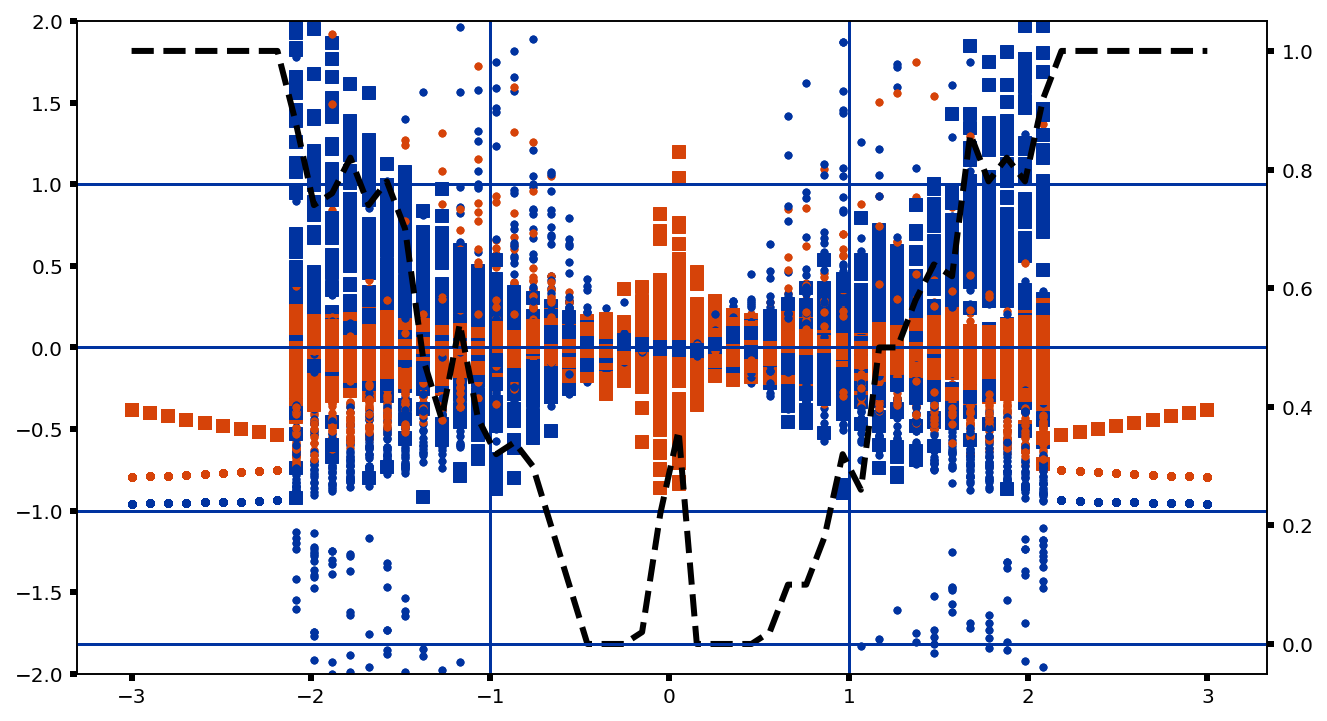

In [7]:
# How often and by how much are the calculated parameters values off the correct, intrinsic values?

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

wind_sigma = 1. # m/s noise

margin = 0.5 # Within 50% of the right value

num_bs = 60
num_tries = 50
bs = np.linspace(-3.*Dact, 3.*Dact, num_bs)

Dobs = np.sqrt(Dact**2 + (2.*bs)**2)
Gamma_obs = Dobs/U1
Vobs = np.abs((2.*Vact*(2.*bs/Dact)/(1. + (2.*bs/Dact)**2)))
Pobs = Pact/(1. + (2.*bs/Dact)**2)

# Show where we expect not to be able to return a good fit
# ind = (Vobs <= 3.*wind_sigma) & (bs/Dact < -1.)
# ax1.axvline(np.max(bs[ind]/Dact), lw=3, ls='--')

# ind = (Vobs <= 3.*wind_sigma) & (bs/Dact > 1.)
# ax1.axvline(np.min(bs[ind]/Dact), lw=3, ls='--')

num_wrongs = np.zeros_like(bs)

for i in range(len(bs)):
    for j in range(num_tries):
    
        profile = wind_profile(t, t0, Vobs[i], U1, U2, bs[i], Gamma_obs[i])
        noisy_profile = profile + normal(scale=wind_sigma, size=len(t))

        try:
            popt, uncertainties, fit_U1, fit_U2 = fit_wind_profile(t, noisy_profile, wind_sigma, 0., Gamma_obs[i], 
                                                   [np.sign(Vobs[i])*1., np.sign(bs[i])*1.])

            fit_Pact, fit_Vact, fit_Dact, fit_bact = calculate_act_values(density, popt[0], Pobs[i], Dobs[i])
            
            if((np.abs(fit_Pact - Pact)/Pact > margin) or\
               (np.abs(fit_Vact - Vact)/Vact > margin) or\
               (np.abs(fit_Dact - Dact)/Dact > margin)) or\
               (np.abs(np.abs(fit_bact) - np.abs(bs[i]))/np.abs(bs[i]) > margin):

                num_wrongs[i] += 1

            # fit_Pact
            ax1.scatter([bs[i]/Dact, bs[i]/Dact], [(fit_Pact - Pact)/Pact, (fit_Pact - Pact)/Pact], 
                       marker='.', color=BoiseState_blue)

            ax1.scatter([bs[i]/Dact, bs[i]/Dact], [(fit_Vact - Vact)/Vact, (fit_Vact - Vact)/Vact], 
                       marker='.', color=BoiseState_orange)
            
            ax1.scatter([bs[i]/Dact, bs[i]/Dact], [(fit_Dact - Dact)/Dact, (fit_Dact - Dact)/Dact], 
                       marker='s', color=BoiseState_blue)
            
            ax1.scatter([bs[i]/Dact, bs[i]/Dact], [(np.abs(fit_bact) - np.abs(bs[i]))/np.abs(bs[i]),
                                                   (np.abs(fit_bact) - np.abs(bs[i]))/np.abs(bs[i])], 
                       marker='s', color=BoiseState_orange)

        except:
            print("%g didn't work!" % (bs[i]/Dact))

ax2.plot(bs/Dact, num_wrongs/num_tries, color='k', lw=3, ls='--')
            
ax1.axhline(-1, color=BoiseState_blue)
ax1.axhline(1, color=BoiseState_blue)
ax1.axvline(-1, color=BoiseState_blue)
ax1.axvline(1, color=BoiseState_blue)
ax1.axhline(0., color=BoiseState_blue)
ax2.axhline(0., color=BoiseState_blue)
ax1.set_ylim([-2, 2])